In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from tqdm.auto import tqdm

sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [121]:
from ast import literal_eval

model_results = pd.read_csv(
    "data/main/stock_selection_via_models.csv",
    index_col="DATE",
    parse_dates=True
)

model_results['SELECTED_STOCKS'] = model_results['SELECTED_STOCKS'].apply(literal_eval)

model_results.head()

,SELECTED_MODEL,MED_OVEREST_LOSS,SELECTED_STOCKS
DATE,,,
1999-01-01,KNeighborsRegressor,0.069576,"[INTU, STZ, JBHT, FDS, CPRT, LOW]"
1999-12-31,AdaBoostRegressor,0.073149,"[FDS, CPRT, RMD, AZO, MNST, JBHT]"
2000-12-29,ElasticNet,0.090349,"[QCOM, CPRT, ADBE, AAPL, INTU, APH]"
2001-12-28,ElasticNet,0.070350,"[NVR, UNH, AJG, RMD, BRO, POOL]"
2002-12-27,KNeighborsRegressor,0.070447,"[TYL, JBHT, NVR, ANSS, LOW, ATVI]"


In [122]:
stocks = model_results.explode("SELECTED_STOCKS")["SELECTED_STOCKS"].unique()

In [123]:
log_returns = pd.read_csv(
    "data/main/master_df.csv",
    index_col="DATE",
    parse_dates=True,
)[stocks]

log_returns.head()

,INTU,STZ,JBHT,FDS,CPRT,LOW,RMD,AZO,MNST,QCOM,...,ATVI,ODFL,WST,FICO,TSCO,GILD,CHD,ROST,ORLY,TJX
DATE,,,,,,,,,,,,,,,,,,,,,
1997-01-10,0.116922,0.012739,0.000000,-0.006079,0.009569,0.028071,0.022989,-0.151550,0.079997,0.109740,...,0.093526,-0.035507,-0.004494,0.025398,-0.018350,0.103867,-0.022473,0.009901,0.023530,0.016574
1997-01-17,-0.035091,-0.038715,-0.004416,-0.018462,0.082240,-0.030129,0.011299,0.041549,-0.052642,0.096331,...,0.008889,0.023811,0.009507,-0.015798,0.000000,0.089996,0.011300,-0.114709,0.067441,-0.059255
1997-01-24,-0.093526,-0.017700,0.026202,0.018462,0.000000,-0.062636,-0.022728,0.005797,-0.084509,0.131297,...,0.021883,-0.060625,-0.009009,0.037504,-0.025001,-0.016529,0.116533,-0.016713,-0.021979,-0.041549
1997-01-31,-0.085943,0.004454,-0.031607,0.006079,0.191055,0.007576,0.005731,0.000000,0.000000,0.002234,...,0.004319,0.012423,0.004515,-0.009245,0.025001,0.083881,0.019803,-0.081918,-0.022473,-0.037042
1997-02-07,-0.084683,-0.017938,0.008889,-0.030772,0.046023,0.003766,0.092709,0.039665,0.097951,0.035091,...,-0.008657,-0.012423,0.008968,0.003091,0.036368,0.037598,0.052076,0.070618,-0.022990,0.001821


---

In [124]:
def portfolio_std(weights, returns):
    cov = returns.cov() * 52 
    return np.sqrt(weights @ cov @ weights)

def portfolio_exp_ret(weights, returns):
    return np.mean(weights @ returns.T) * 52

def portfolio_sharpe(weights, returns):
    std = portfolio_std(weights, returns)
    exp_ret = portfolio_exp_ret(weights, returns)
    return exp_ret / std

def max_sharpe_opt(init_weights, returns):
    n_stocks = len(returns.columns)
    bounds = [(0, 1) for _ in range(n_stocks)]
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    
    opt_result = minimize(
        lambda w: -portfolio_sharpe(w, returns=returns),
        x0=init_weights,
        bounds=bounds,
        constraints=constraints
    )

    return opt_result.x

In [213]:
allocations = pd.DataFrame(columns=stocks, index=model_results.index)
n_stocks = len(model_results["SELECTED_STOCKS"].iloc[0])

for date in tqdm(model_results.index):
    portfolio = model_results.loc[date, "SELECTED_STOCKS"]
    port_const_returns = log_returns[portfolio]
    log_returns_slice = port_const_returns.loc[:date][:-1]
    one_over_n = np.array([1/n_stocks] * n_stocks)
    max_sharpe_weights = max_sharpe_opt(one_over_n, log_returns_slice)
    for i, stock in enumerate(portfolio):
        allocations.loc[date, stock] = max_sharpe_weights[i]

  0%|          | 0/25 [00:00<?, ?it/s]

In [242]:
min_weight = 0.01

earliest_date = model_results.index.min()
constituent_returns = log_returns[stocks].loc[earliest_date:]

weekly_allocations = allocations.replace(np.nan, 0)
weekly_allocations = weekly_allocations.reindex(constituent_returns.index)
weekly_allocations = weekly_allocations.ffill()

weekly_allocations = weekly_allocations[weekly_allocations >= min_weight]
weekly_allocations = weekly_allocations.div(weekly_allocations.sum(axis=1), axis=0)
weekly_allocations = weekly_allocations.replace(np.nan, 0)

weekly_allocations.head()

,INTU,STZ,JBHT,FDS,CPRT,LOW,RMD,AZO,MNST,QCOM,...,ATVI,ODFL,WST,FICO,TSCO,GILD,CHD,ROST,ORLY,TJX
DATE,,,,,,,,,,,,,,,,,,,,,
1999-01-01,0.0,0.325362,0.0,0.224304,0.08053,0.369805,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-01-08,0.0,0.325362,0.0,0.224304,0.08053,0.369805,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-01-15,0.0,0.325362,0.0,0.224304,0.08053,0.369805,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-01-22,0.0,0.325362,0.0,0.224304,0.08053,0.369805,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-01-29,0.0,0.325362,0.0,0.224304,0.08053,0.369805,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


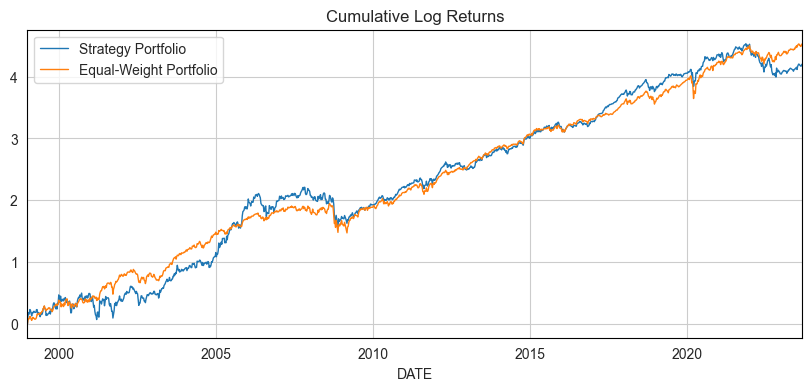

In [274]:
strategy_returns = (weekly_allocations * constituent_returns).sum(axis=1)
strategy_equity = strategy_returns.cumsum()

ew_portfolio_returns = (constituent_returns.div(len(stocks))).sum(axis=1)
ew_portfolio_returns.loc[earliest_date] = 0
ew_portfolio_equity = ew_portfolio_returns.cumsum()

plt.figure(figsize=(10, 4))
ax = strategy_equity.plot()
ew_portfolio_equity.plot(ax=ax)
plt.title("Cumulative Log Returns")
plt.legend(["Strategy Portfolio", "Equal-Weight Portfolio"])
plt.show()

In [279]:
(np.mean(ew_portfolio_returns) * 52) / (np.std(ew_portfolio_returns) * np.sqrt(52))

0.978513645502813